In [1]:
import numpy as np
import torch
import torch.nn as nn
import h5py as h5
import os
import sys
import pickle
sys.path.append("../")
from models import PracticalBNCNN, NormedBNCNN, DalesBNCNN, DalesSSCNN, SSCNN, BNCNN, PracticalBNCNN, DalesHybrid, DalesSkipBNCNN, SkipBNBNCNN
#import metrics
import matplotlib.pyplot as plt
from utils.deepretina_loader import loadexpt
from utils.physiology import Physio
import utils.intracellular as intracellular
import utils.batch_compute as bc
import utils.retinal_phenomena as rp
import utils.stimuli as stimuli
import pyret.filtertools as ft
import scipy
import re
import pickle
from tqdm import tqdm
import gc
import resource
import time
import math

def normalize(x):
    return (x-x.mean())/(x.std()+1e-7)

def retinal_phenomena_figs(bn_cnn):
    rp.step_response(bn_cnn)
    rp.osr(bn_cnn)
    rp.reversing_grating(bn_cnn)
    rp.contrast_adaptation(bn_cnn, .35, .05)
    rp.motion_anticipation(bn_cnn)
    
#If you want to use stimulus that isnt just boxes
def prepare_stim(stim, stim_type):
    if stim_type == 'boxes':
        return 2*stim - 1
    elif stim_type == 'flashes':
        stim = stim.reshape(stim.shape[0], 1, 1)
        return np.broadcast_to(stim, (stim.shape[0], 38, 38))
    elif stim_type == 'movingbar':
        stim = block_reduce(stim, (1,6), func=np.mean)
        stim = pyret.stimulustools.upsample(stim.reshape(stim.shape[0], stim.shape[1], 1), 5)[0]
        return np.broadcast_to(stim, (stim.shape[0], stim.shape[1], stim.shape[1]))
    elif stim_type == 'lines':
        stim_averaged = np.apply_along_axis(lambda m: np.convolve(m, 0.5*np.ones((2,)), mode='same'), 
                                            axis=1, arr=stim)
        stim = stim_averaged[:,::2]
        # now stack stimulus to convert 1d to 2d spatial stimulus
        return stim.reshape(-1,1,stim.shape[-1]).repeat(stim.shape[-1], axis=1)
    else:
        print("Invalid stim type")
        assert False
    
def index_of(arg, arr):
    for i in range(len(arr)):
        if arg == arr[i]:
            return i
    return -1

In [165]:
import importlib
sys.path.append("/home/juyoungk/modules/1d-whitenoise-models/")
import my
my.figure_setting()
#
import pyret
import pyret.filtertools as ft
from pyret.nonlinearities import Binterp, RBF, Sigmoid
from pyret.visualizations import plot_sta, play_sta
plt.rcParams['animation.html'] = 'jshtml'
from IPython.display import HTML
%matplotlib inline

['seaborn-talk', 'seaborn-notebook', 'fivethirtyeight', 'tableau-colorblind10', 'seaborn-colorblind', 'seaborn-dark-palette', 'bmh', 'grayscale', 'Solarize_Light2', 'seaborn-ticks', '_classic_test', 'classic', 'seaborn-deep', 'seaborn-muted', 'seaborn-bright', 'seaborn-darkgrid', 'seaborn-whitegrid', 'seaborn-pastel', 'seaborn-paper', 'ggplot', 'seaborn-dark', 'dark_background', 'seaborn-poster', 'seaborn', 'fast', 'seaborn-white']


In [3]:
DEVICE = torch.device("cuda:1")
torch.cuda.empty_cache()

### Load 'Natural scene' Model

In [79]:
grand_folder = "BNCNN"
exp_folder = "../training_scripts/"+grand_folder
_, model_folders, _ = next(os.walk(exp_folder))
for i,f in enumerate(model_folders):
    model_folders[i] = grand_folder + "/" + f

In [80]:
model_folders = sorted(model_folders)
print("\n".join(model_folders))

BNCNN/BNCNN_0_lr0.01_l20.001
BNCNN/BNCNN_1_lr0.01_l20.0001
BNCNN/BNCNN_2_lr0.005_l20.001
BNCNN/BNCNN_3_lr0.005_l20.0001
BNCNN/BNCNN_4_lr0.001_l20.001
BNCNN/BNCNN_5_lr0.001_l20.0001


In [82]:
model_id = 5
epoch_id = 84
#
file = "../training_scripts/"+model_folders[model_id]+"/test_epoch_"+str(epoch_id)+".pth"
try:
    with open(file, "rb") as fd:
        temp = torch.load(fd)
except:
    pass
#
print(temp['model'])
#
model_ns = BNCNN() 
model_ns.load_state_dict(temp["model_state_dict"])
model_ns.eval();

BNCNN(
  (sequential): Sequential(
    (0): Conv2d(40, 8, kernel_size=(15, 15), stride=(1, 1))
    (1): Flatten()
    (2): BatchNorm1d(10368, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
    (3): GaussianNoise(std=0.3, trainable=False, adapt=False)
    (4): ReLU()
    (5): Reshape()
    (6): Conv2d(8, 8, kernel_size=(11, 11), stride=(1, 1))
    (7): Flatten()
    (8): BatchNorm1d(5408, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
    (9): GaussianNoise(std=0.3, trainable=False, adapt=False)
    (10): ReLU()
    (11): Linear(in_features=5408, out_features=5, bias=True)
    (12): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Softplus(beta=1, threshold=20)
  )
)


In [7]:
print(temp.keys())
temp['test_pearson']

dict_keys(['model', 'model_state_dict', 'optim_state_dict', 'loss', 'epoch', 'val_loss', 'val_acc', 'test_pearson', 'norm_stats'])


0.81770015648406

In [ ]:
conv_layers = ['sequential.2', 'sequential.8']

In [8]:
# Stimulus Loading --> more systematic ??
cells = "all"
dataset = '15-10-07'
stim_type = 'naturalscene'
norm_stats = [temp['norm_stats']['mean'], temp['norm_stats']['std']]
test_data = loadexpt(dataset, cells, stim_type, 'test', 40, 0, norm_stats=norm_stats)
test_x = torch.from_numpy(test_data.X)
print(test_x.shape)

torch.Size([5956, 40, 50, 50])


In [9]:
data = dict()

In [22]:
# Data loading as Torch tensor (naturalscene)
test_data = loadexpt(dataset, cells, 'naturalscene', 'test', 40, 0, norm_stats=norm_stats)
data["ns"] = {"X":torch.from_numpy(test_data.X), "y":torch.from_numpy(test_data.y)}

In [23]:
# Data loading as Torch tensor (whitenoise)
test_data = loadexpt(dataset, cells, 'whitenoise', 'test', 40, 0, norm_stats=norm_stats)
data["wn"] = {"X":torch.from_numpy(test_data.X), "y":torch.from_numpy(test_data.y)}

In [25]:
gc.collect()
max_mem_used = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
print("Memory Used: {:.2f} mb".format(max_mem_used / 1024))

Memory Used: 2618.14 mb


Text(0.5, 1.0, 'whitenoise response (y)')

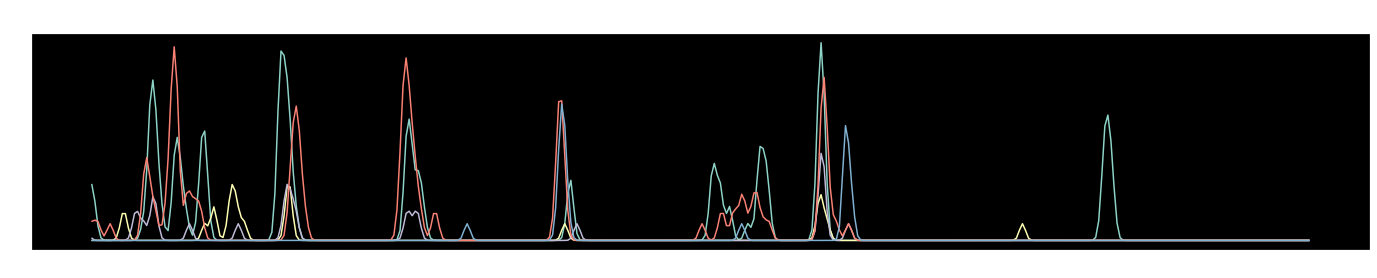

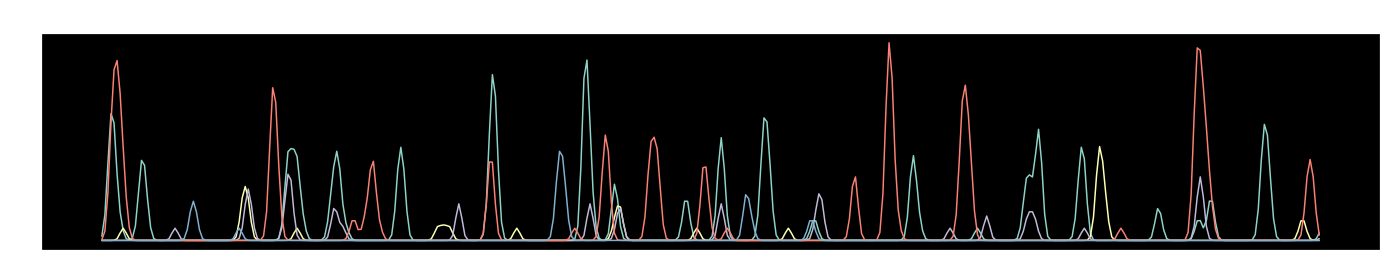

In [42]:
# data plot
y = data["ns"]["y"][0:400].detach().numpy()
plt.figure(figsize=(24,4))
plt.plot(y)
plt.title("Natural scene response (y)", fontdict={'fontsize':27})
y = data["wn"]["y"][0:400].detach().numpy()
plt.figure(figsize=(24,4))
plt.plot(y)
plt.title("whitenoise response (y)", fontdict={'fontsize':27})

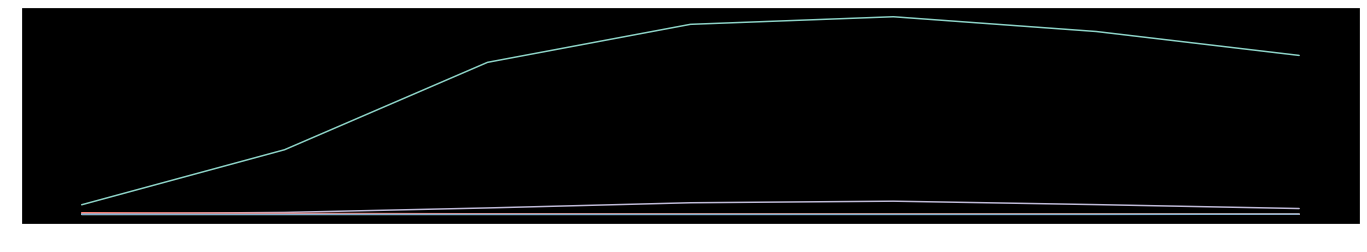

In [136]:
# Check model output
# Check whether model is deterministic: model.eval()
model = BNCNN()
model.load_state_dict(temp["model_state_dict"])
model.eval()
# Adjust timing for gradient computation
i = 328 # start frame
interval = 7
x = data["ns"]['X'][i:i+interval]
plt.figure(figsize=(24,4))
plt.plot(model(x).detach().numpy())

In [448]:
importlib.reload(my)
#
def inspect_gradient(models, x, label=None):
    """
    Compute the mean gradient of model output relative to x [time, space1, space2] space, 
    and visualize over cells (decompose for 3D tensor).
    
    Parameters
    ----------
    model: model or a list of models. [model1, model2, ..]
    x : batch of torch tensor [n_samples, channels(40), x(50), y(50)]
    """ 
    if type(x) is np.ndarray:
        x = torch.from_numpy(x)
    
    if x.dim() == 3:
        # add batch dimension
        x = x[None, :, :, :]
    
    x.requires_grad_(True);
    
    if type(models) is not list:
        models = [models]
        
    for model in models:
        model.eval()    
    
    if label is None:
        label = ['' for m in models]
    assert len(label) == len(models)
    
    numModels = len(models)

    # Fig for model repsonse plots
    fig, axes_output = plt.subplots(1, numModels, figsize=(6*numModels, 2.5))
    
    for m in range(numModels):
        model = models[m]
        #model.eval()
        # compute model output
        r = model(x) # multiple cells. Graph for gradient. 
        # Average over batch (This is the FINAL output)
        output = r.mean(dim=0)
    
        # plot model output in same order as batch
        if numModels == 1:
            ax = axes_output
        else:
            ax = axes_output[m]
        
        ax.plot(r.detach().numpy())
        ax.set_title("%s"%label[m], fontdict={'fontsize':25})
        ax.set_xlabel('batch id (~ time)', fontdict={'fontsize':25})
        
        # compute gradient of output relative to input batch x
        grad_visualize(output, x)
        
    # Differential gradient between the first 2 models.
    if len(models) > 1:
        print('Gradient on differential output between 2 models.')
        # output is the difference
        r = models[0](x) - models[1](x) 
        output = r.mean(dim=0) # Average over batch
        #
        grad_visualize(output, x)
        
    
def grad_visualize(output, x, label=None):
    """
    Gradient of output w.r.t input x. (x should be a leaf node of the output.)
    Visualize (averaged) x.grad.
    """
    
    n_cells = output.shape[0]
    
    # fig for spatial & temporal profiles
    fig, axes = plt.subplots(1, n_cells, figsize=(18, 2.5))
    fig_t, axes_t = plt.subplots(1, n_cells, figsize=(18, 2.5))

    for i in range(n_cells):        
        # Manually zero the gradients not to accumulate all the gradients
        if x.grad is not None:
            x.grad.data.zero_()

        if i == n_cells-1:
            output[i].backward() 
        else:
            output[i].backward(retain_graph=True)

        # gradient mean over batch (usually sequential data)
        grad_mean = x.grad.mean(dim=0).detach().numpy()
        
        # Decompose
        s, t = ft.decompose(grad_mean)

        if n_cells > 1:
            ax_spatial = axes[i]
            ax_temporal = axes_t[i]
        else:
            ax_spatial = axes
            ax_temporal = axes_t
            
        # Visualize
        if grad_mean.ndim == 2:
            my.rf_imshow(grad_mean, ax=ax_spatial) 
        else:
            my.rf_imshow(s, ax=ax_spatial) 
        ax_spatial.axis('off')
        ax_temporal.plot(t)
        ax_temporal.set_yticks([0]) 

Gradient on differential output between 2 models.


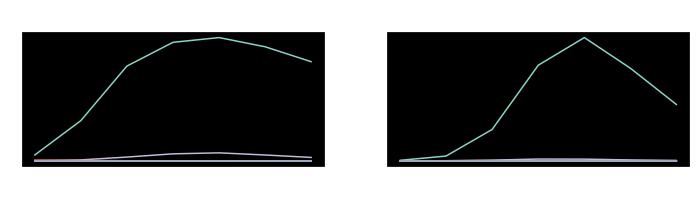

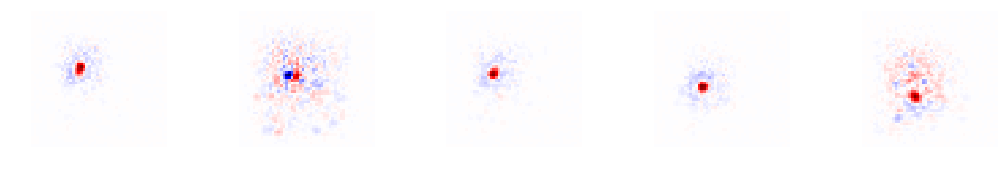

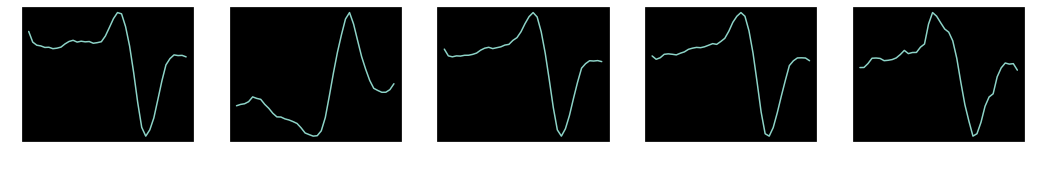

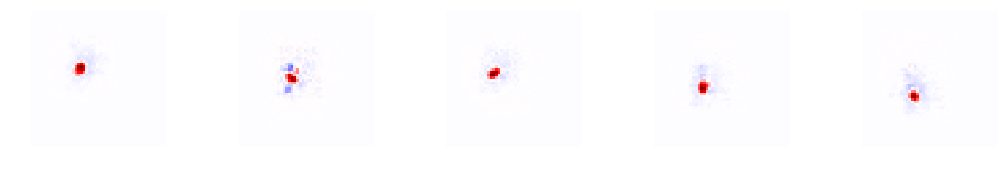

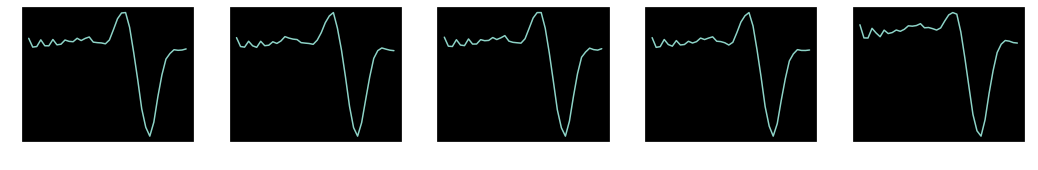

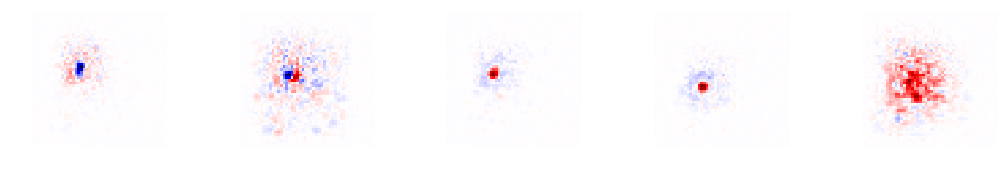

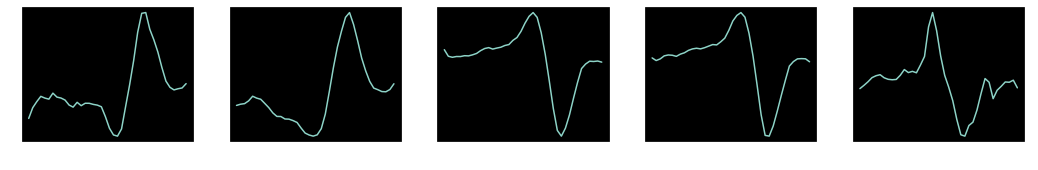

In [338]:
i = 328      # start frame in data
interval = 7
#
inspect_gradient([model_ns, model_wn], data["ns"]['X'][i:i+interval], label=['ns model','wn model'])
#inspect_gradient(model_wn, data["ns"]['X'][i:i+interval])

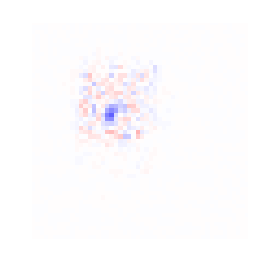

<Figure size 432x288 with 0 Axes>

In [71]:
play_sta(grad_mean)

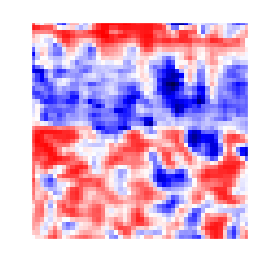

<Figure size 432x288 with 0 Axes>

In [257]:
# play stimulus
play_sta(x[0].detach().numpy()) # last batchdd

In [226]:
# Loading model trained on whitenoise stimulus
grand_folder = "BNCNN-wn"
exp_folder = "../training_scripts/"+grand_folder
_, model_folders, _ = next(os.walk(exp_folder))
for i,f in enumerate(model_folders):
    model_folders[i] = grand_folder + "/" + f

In [227]:
model_folders = sorted(model_folders)
print("\n".join(model_folders))

BNCNN-wn/BNCNN-wn_0_lr0.01_l20.001
BNCNN-wn/BNCNN-wn_1_lr0.01_l20.0001
BNCNN-wn/BNCNN-wn_2_lr0.005_l20.001
BNCNN-wn/BNCNN-wn_3_lr0.005_l20.0001
BNCNN-wn/BNCNN-wn_4_lr0.001_l20.001
BNCNN-wn/BNCNN-wn_5_lr0.001_l20.0001


In [228]:
model_id = 4
epoch_id = 84
#
file = "../training_scripts/"+model_folders[model_id]+"/test_epoch_"+str(epoch_id)+".pth"
try:
    with open(file, "rb") as fd:
        temp = torch.load(fd)
except:
    pass
#
print(temp['model'])
#
model_wn = BNCNN() 
model_wn.load_state_dict(temp["model_state_dict"])
model_wn.eval()

BNCNN(
  (sequential): Sequential(
    (0): Conv2d(40, 8, kernel_size=(15, 15), stride=(1, 1))
    (1): Flatten()
    (2): BatchNorm1d(10368, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
    (3): GaussianNoise(std=0.3, trainable=False, adapt=False)
    (4): ReLU()
    (5): Reshape()
    (6): Conv2d(8, 8, kernel_size=(11, 11), stride=(1, 1))
    (7): Flatten()
    (8): BatchNorm1d(5408, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
    (9): GaussianNoise(std=0.3, trainable=False, adapt=False)
    (10): ReLU()
    (11): Linear(in_features=5408, out_features=5, bias=True)
    (12): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Softplus(beta=1, threshold=20)
  )
)


BNCNN(
  (sequential): Sequential(
    (0): Conv2d(40, 8, kernel_size=(15, 15), stride=(1, 1))
    (1): Flatten()
    (2): BatchNorm1d(10368, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
    (3): GaussianNoise(std=0.05, trainable=False, adapt=False, momentum=0.95)
    (4): ReLU()
    (5): Reshape()
    (6): Conv2d(8, 8, kernel_size=(11, 11), stride=(1, 1))
    (7): Flatten()
    (8): BatchNorm1d(5408, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
    (9): GaussianNoise(std=0.05, trainable=False, adapt=False, momentum=0.95)
    (10): ReLU()
    (11): Linear(in_features=5408, out_features=5, bias=True)
    (12): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Softplus(beta=1, threshold=20)
  )
)

Text(0.5, 1.0, 'Real retina spiking rate')

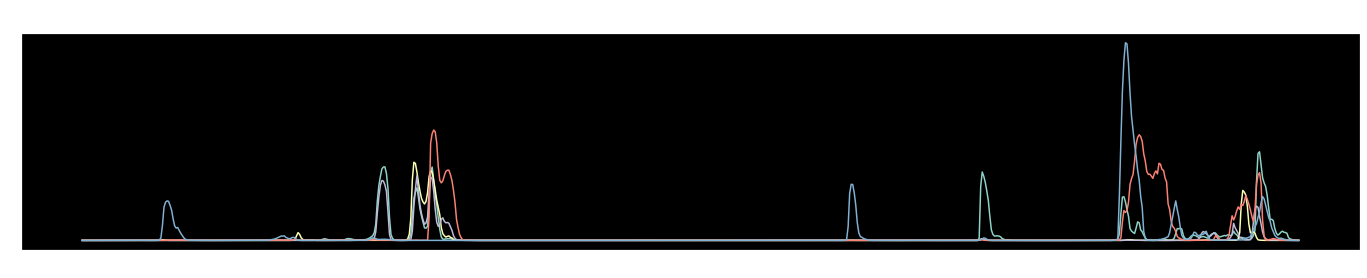

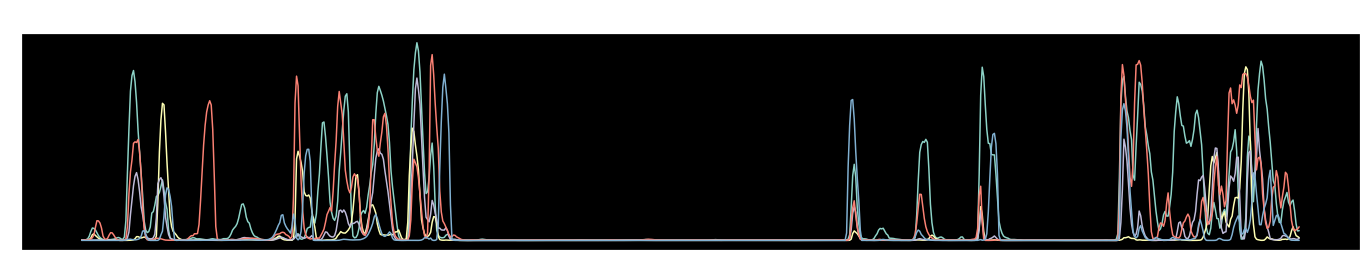

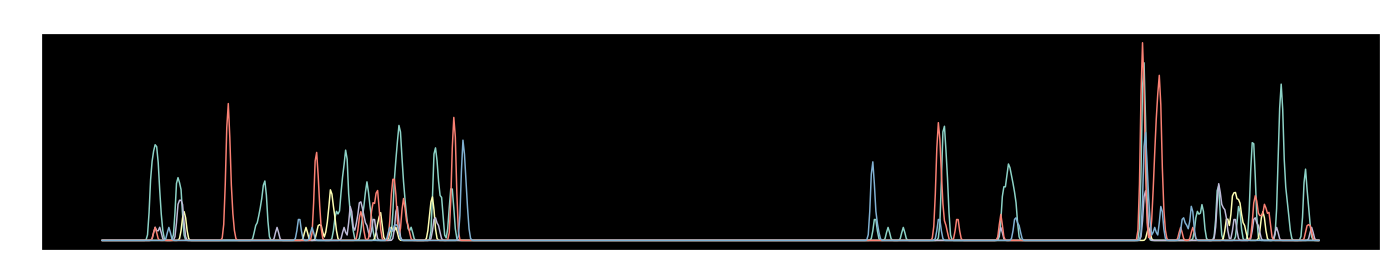

In [230]:
# Whitenoise model prediction to Naturalscene
i = 1000 # start frame
interval = 800
x = data["ns"]['X'][i:i+interval]
y = data["ns"]['y'][i:i+interval]
#
plt.figure(figsize=(24,4))
plt.plot(model_wn(x).detach().numpy())
plt.title("NS predction of model trained on Whitenoise", fontdict={'fontsize':27})
#
plt.figure(figsize=(24,4))
plt.plot(model_ns(x).detach().numpy())
plt.title("NS predction of model trained on Naturalscene", fontdict={'fontsize':27})
# real data
plt.figure(figsize=(24,4))
plt.plot(y.detach().numpy())
plt.title("Real retina spiking rate", fontdict={'fontsize':27})

tensor([3.1946, 0.0099, 0.7638, 1.5709, 0.0188], grad_fn=<MeanBackward0>)


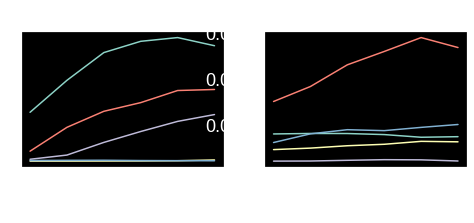

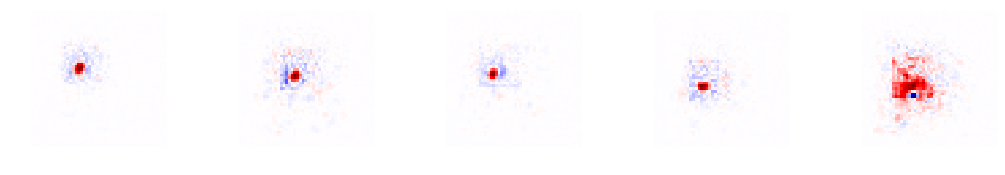

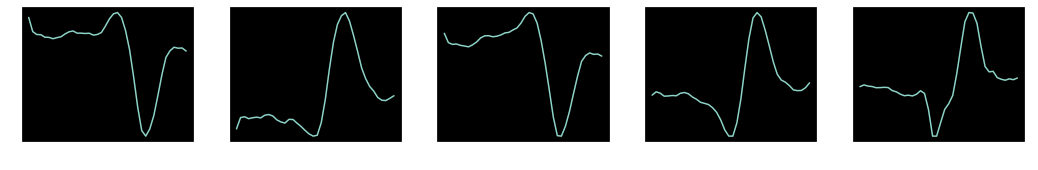

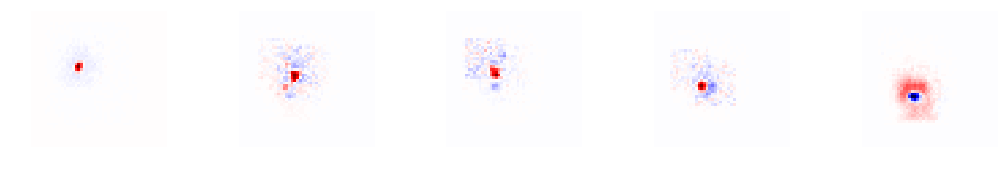

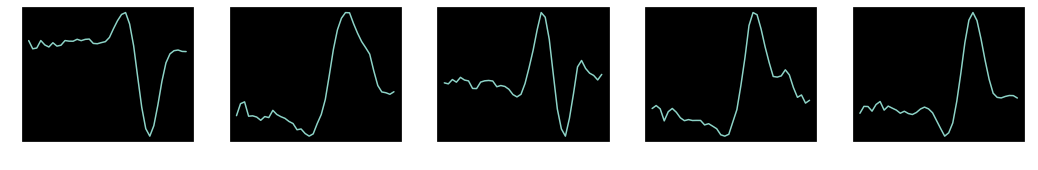

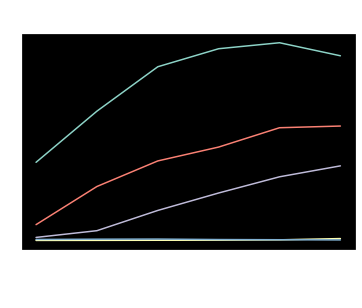

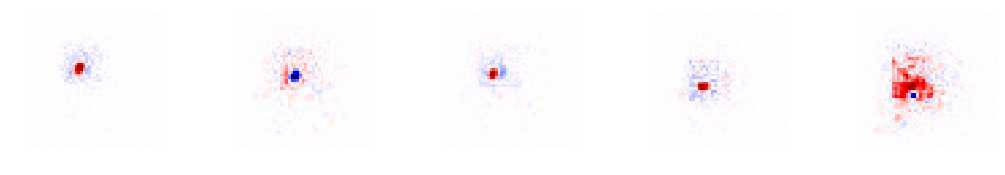

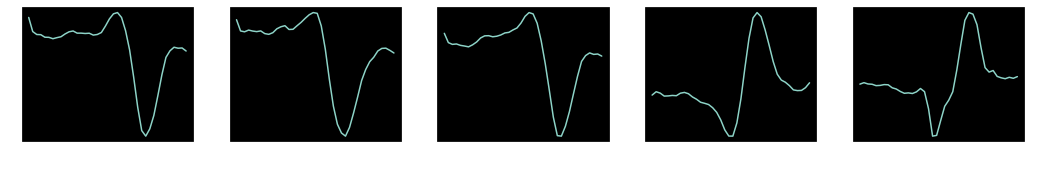

In [300]:
# pick prominant time
i = 1000 + 30      # start frame in data
interval = 6
x = data["ns"]['X'][i:i+interval]

# How does the gradient look like?
inspect_gradient([model_ns, model_wn], x, label = ['ns model','wn model'])
#inspect_gradient(model_wn, x)

# How does the subtractive gradient look like?
discriminate_gradient([model_ns, model_wn], x)

# what was the stimulus?
#play_sta(x[int(interval/2)].detach().numpy())

### stimulus

In [305]:
stimuli.driftingbar??

Signature: stimuli.driftingbar(velocity, width, intensity=-1.0, x=(-30, 30))
Source:   
def driftingbar(velocity, width, intensity=-1., x=(-30, 30)):
    """Drifting bar

    Usage
    -----
    >>> centers, stim = driftingbar(0.08, 2)

    Parameters
    ----------
    velocity : float
        bar velocity in pixels / frame (if negative, the bar reverses direction)

    width : int
        bar width in pixels

    Returns
    -------
    centers : array_like
        The center positions of the bar at each frame in the stimulus

    stim : array_like
        The spatiotemporal drifting bar movie
    """
    npts = 1 + int((x[1] - x[0]) / velocity)
    centers = np.linspace(x[0], x[1], npts)
    return centers, velocity, concat(np.stack(map(lambda x: bar((x, 0), width, np.Inf, us_factor=5, blur=0.), centers)))
File:      ~/modules/torch-deep-retina/utils/stimuli.py
Type:      function


In [331]:
centers, vel, stim = stimuli.driftingbar(0.2, 2)

In [332]:
stim.shape

(261, 40, 50, 50)

[[0.16918709 0.15425543 0.02309343]
 [0.62280472 0.31903885 0.72343774]]
[[[0.16918709 0.15425543]
  [0.02309343 0.16918709]
  [0.15425543 0.02309343]]

 [[0.62280472 0.31903885]
  [0.72343774 0.62280472]
  [0.31903885 0.72343774]]]


(2, 3, -1)

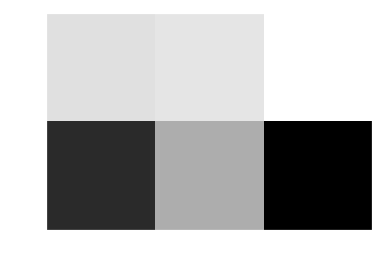

In [399]:
# 2D representation of drifiting bar
# Can I generate in the torch graph?
# (40x50) -> (40x50x50)
a = np.random.rand(2,3) # time x space
print(a)
plt.imshow(a)

b = np.repeat(a, 2, axis=0).reshape(2,3,-1)
print(b)

In [434]:
a = np.random.rand(1,2,3)
a = torch.from_numpy(a)
asize = a.size()
print(a)
print(asize)

dim2 = 5
b = a.reshape(-1, 1).repeat(1,dim2).reshape(asize + (-1,))
print(b)
b.size()
# input - (batch, time, space)
# output - (batch, time, space, space2)


tensor([[[0.4129, 0.1023, 0.9986],
         [0.1486, 0.8139, 0.2958]]], dtype=torch.float64)
torch.Size([1, 2, 3])
tensor([[[[0.4129, 0.4129, 0.4129, 0.4129, 0.4129],
          [0.1023, 0.1023, 0.1023, 0.1023, 0.1023],
          [0.9986, 0.9986, 0.9986, 0.9986, 0.9986]],

         [[0.1486, 0.1486, 0.1486, 0.1486, 0.1486],
          [0.8139, 0.8139, 0.8139, 0.8139, 0.8139],
          [0.2958, 0.2958, 0.2958, 0.2958, 0.2958]]]], dtype=torch.float64)


torch.Size([1, 2, 3, 5])

In [436]:
def copy_dim1_to_2(x, dim2):
    """
    convert 1D bar temporal pattern (2D) into 2D grating temporal pattern (3D)
    x: 2D numpy array (time, space)
    return - 3D numpy array (time, space, space2)
    """
    return np.repeat(x, dim2, axis=1).reshape(x.shape + (-1,))

def copy_last_dim_and_add(x, dim2):
    """
    copy the last dimension and add new dimension
    x: torch tensor (n dim)
    return - (n+1 dim) tensor
    """
    xsize = x.size()
    return x.reshape(-1, 1).repeat(1,dim2).reshape(xsize + (-1,))

In [437]:
# new model class for 1D input?
class model_1D_input(nn.Module):
    def __init__(self, model, dim2):
        super(model_1D_input,self).__init__()
        self.name = 'Model_1D_input'
        self.model = model
        self.dim2 = dim2
        
    def forward(self, x):
        x = x.copy_last_dim_and_add(self.dim2)
        return self.model(x)    

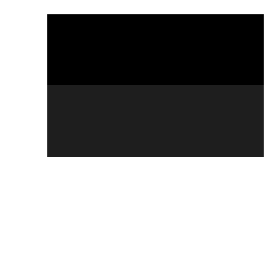

In [401]:
aa = copy_dim1_to_2(a, 3)
plt.imshow(aa[0])

In [439]:
model_ns_1d = model_1D_input(model_ns, 50)
model_wn_1d = model_1D_input(model_wn, 50)

Gradient on differential output between 2 models.


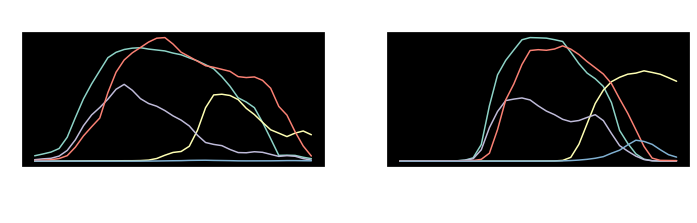

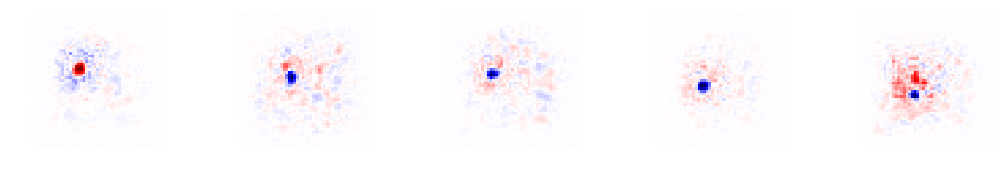

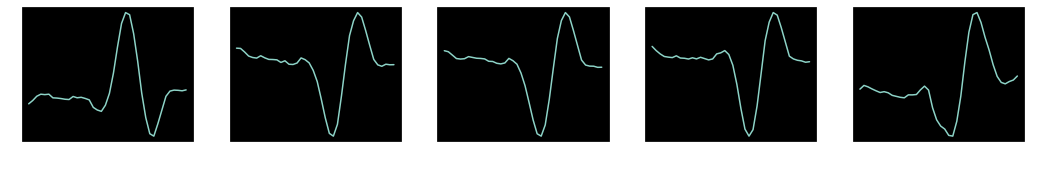

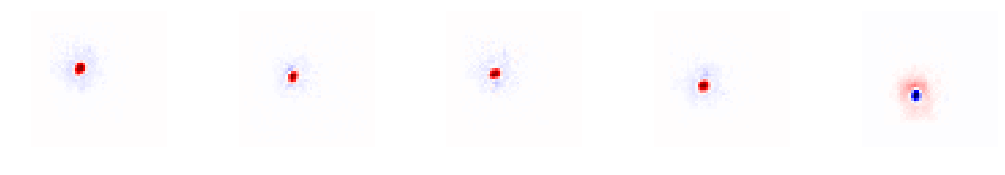

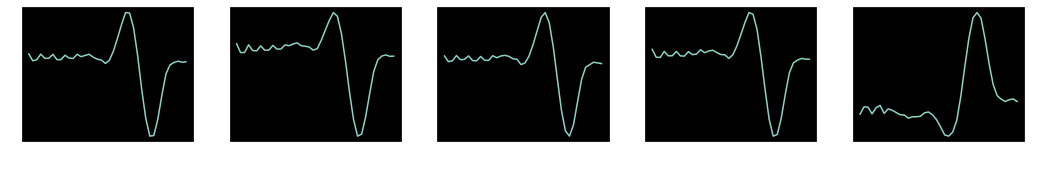

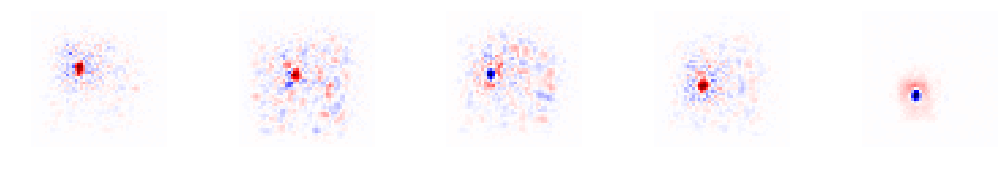

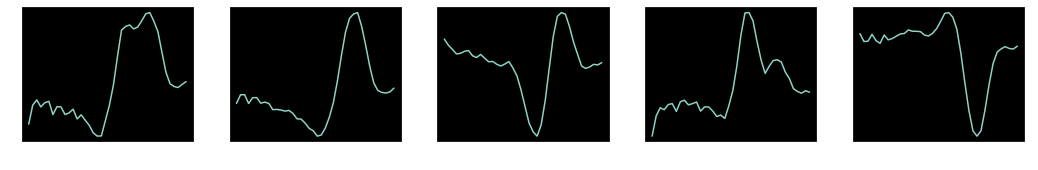

In [450]:
inspect_gradient([model_ns, model_wn], stim[65:100], label = ['ns model','wn model'])

In [ ]:
# update image by adding gradient
learning_rate = 0.01
epochs = 20

for 


## Look at model performances

In [10]:
n_epochs = 250
best_folder_by_loss = ""
best_loss = 100
best_folder_by_val_loss = ""
best_val_loss = 100
best_folder_by_val_acc = ""
best_val_acc = -100
best_folder_by_test_acc = ""
best_test_acc = -100
best_folder_by_intr_cor = ""
best_intr_cor = -1

results_file_name = grand_folder + "_analysis_results.txt"
results_file = open(results_file_name, 'a')
batch_compute_size = 2000
model_stats = dict()

# load the losses
print("Using layers:", " and ".join(conv_layers))
for folder in model_folders:
    model_stats[folder] = dict()
    starttime = time.time()
    losses = []
    val_losses = []
    val_accs = []
    for i in range(n_epochs):
        file = "../training_scripts/"+folder+"/test_epoch_{0}.pth".format(i)
        try:
            with open(file, "rb") as fd:
                temp = torch.load(fd)
            losses.append(temp['loss'])
            val_losses.append(temp['val_loss'])
            val_accs.append(temp['val_acc'])
        except:
            break
    bn_cnn = temp['model']
    bn_cnn = bn_cnn.to(DEVICE)
    bn_cnn.eval()
    print("Folder:", folder)
    results_file.write(folder + "\n")
    print("Final Loss:", losses[-1])
    results_file.write("Final Loss:"+ str(losses[-1]) + "\n")
    model_stats[folder]['TrainLoss'] = losses[-1]
    print("Final Val:", val_losses[-1])
    results_file.write("Final Val:"+ str(val_losses[-1]) + "\n")
    model_stats[folder]['ValLoss'] = val_losses[-1]
    print("Final Val Acc:", val_accs[-1])
    results_file.write("Val Acc:"+ str(val_accs[-1]) + "\n")
    model_stats[folder]['ValAcc'] = val_accs[-1]
    if(math.isnan(losses[-1]) or math.isnan(val_losses[-1]) or math.isnan(val_accs[-1])):
        print("NaN results, continuing...\n\n\n\n")
        results_file.write("NaN results, continuing...\n\n\n\n")
        continue

    model_response = bc.batch_compute_model_response(test_data.X, bn_cnn, batch_compute_size, 
                                                     insp_keys=set(conv_layers))    
    avg_test_acc = np.mean([scipy.stats.pearsonr(model_response['output'][:, i], test_data.y[:, i])[0] 
                            for i in range(test_data.y.shape[-1])])
    if math.isnan(avg_test_acc):
        print("NaN results, continuing...\n\n\n\n")
        results_file.write("NaN results, continuing...\n\n\n\n")
        continue
    print("\nFinal Test Acc:", avg_test_acc)
    results_file.write("Final Test Acc:"+ str(avg_test_acc) + "\n")
    model_stats[folder]['TestAcc'] = avg_test_acc
    with open("../training_scripts/"+folder+"/hyperparams.txt", 'a') as f:
        f.write("\nTest Ganglion Cell Correlation: " + str(avg_test_acc))
    if losses[-1] < best_loss:
        best_loss = losses[-1]
        best_folder_by_loss = folder
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        best_folder_by_val_loss = folder
    if val_accs[-1] > best_val_acc:
        best_val_acc = val_accs[-1]
        best_folder_by_val_acc = folder
    if avg_test_acc > best_test_acc:
        best_test_acc = avg_test_acc
        best_folder_by_test_acc = folder
    plt.plot(normalize(model_response['output'][:400, 0]))
    plt.plot(normalize(test_data.y[:400,0]), alpha=.7)
    plt.legend(["model", "data"])
    plt.title("Firing Rate")
    plt.show()
    plt.plot(losses)
    plt.plot(val_losses)
    plt.legend(["TrainLoss", "ValLoss"])
    plt.title("Loss Curves")
    plt.ylim([-6, 6])
    plt.show()
    retinal_phenomena_figs(bn_cnn)
    plt.show()
    
    if avg_test_acc < .5 or losses[-1] > 1:
        print("Skipping further analysis due to poor results...\n\n\n\n")
        results_file.write("Skipping further analysis due to poor results...\n\n\n\n")
        continue
    print("Calculating model responses...\n")
    # Computes the model responses for each stimulus 
    # and interneuron type labels y_true (0 for bipolar, 1 for amacrine, 2 for horizontal)
    y_true = []
    filter_length = 40
    model_responses = dict()
    for i in tqdm(range(len(files))):
        file_name = files[i]
        if 'bipolar' in file_name:
            for j in range(num_pots[i]):
                y_true.append(0)
        elif 'amacrine' in file_name:
            for j in range(num_pots[i]):
                y_true.append(1)
        else:
            for j in range(num_pots[i]):
                y_true.append(2)
        for k in stims.keys():
            stim = stims[k][i]
            padded_stim = intracellular.pad_to_edge(scipy.stats.zscore(stim))
            if k not in model_responses:
                model_responses[k] = []
            model_responses[k].append(bc.batch_compute_model_response(stimuli.concat(padded_stim),
                                                                      bn_cnn,batch_compute_size, 
                                                                      insp_keys=set(conv_layers)))
            # Reshape potentially flat layers
            for j,cl in enumerate(conv_layers):
                if len(model_responses[k][-1][cl].shape) <= 2:
                    try:
                        model_responses[k][-1][cl] = model_responses[k][-1][cl].reshape((-1,8,36,36))
                    except:
                        model_responses[k][-1][cl] = model_responses[k][-1][cl].reshape((-1,8,26,26))
    
    # uses classify to get the most correlated cell/layer/subtype for each interneuron recording. 
    # Stored in all_cell_info. y_pred does a baseline "classification": record the convolutional 
    # layer that the most correlated cell is in.
    # See intracellular.py for more info
    # This takes a really long time to run. 
    print("Calculating intercellular correlations...\n")
    all_cell_info = dict()
    y_pred = dict()
    for i in tqdm(range(len(files))):
        for k in stims.keys():
            model_response = model_responses[k][i]
            stim = stims[k][i]
            for j in range(mem_pots[k][i].shape[0]):
                potential = mem_pots[k][i][j]
                cell_info = intracellular.classify(potential, model_response, stim.shape[0], 
                                                   layer_keys=conv_layers)
                #layer, channel,(row, col), cor_coef = cell_info
                if k not in all_cell_info:
                    all_cell_info[k] = []
                    y_pred[k] = []
                all_cell_info[k].append(cell_info)
                y_pred[k].append(index_of(cell_info[0], conv_layers))
    
    model_stats[folder]['all_cell_info'] = all_cell_info
    # Average intracellular correlation. RIP.
    avg_intr_cor = np.mean(np.asarray([[all_cell_info[k][i][-1] for i in range(len(all_cell_info[k]))] for k in all_cell_info.keys()]))
    print("Mean intracellular:", avg_intr_cor)
    results_file.write("Mean intracellular:" + str(avg_intr_cor) + "\n")
    model_stats[folder]['IntrCor'] = avg_intr_cor
    std = np.std(np.asarray([[all_cell_info[k][i][-1] for i in range(len(all_cell_info[k]))] for k in all_cell_info.keys()]))
    print("Std intracellular:", std)
    m = np.min(np.asarray([[all_cell_info[k][i][-1] for i in range(len(all_cell_info[k]))] for k in all_cell_info.keys()]))
    print("Min intracellular:", m)
    results_file.write("Min intracellular:" + str(m) + "\n")
    m = np.max(np.asarray([[all_cell_info[k][i][-1] for i in range(len(all_cell_info[k]))] for k in all_cell_info.keys()]))
    print("Max intracellular:", m)
    results_file.write("Max intracellular:" + str(m) + "\n")
    
    if avg_intr_cor > best_intr_cor:
        best_intr_cor = avg_intr_cor
        best_folder_by_intr_cor = folder
    
    stim_type = 'boxes'
    # Make example correlation map
    model_response = model_responses[stim_type][-1]
    potential = mem_pots[stim_type][-1][-1]
    layer, k, (i,j), r = all_cell_info[stim_type][-1]
    print("Layer", layer, "correlation map")
    plt.imshow(intracellular.correlation_map(potential, model_response[layer][:, k]))
    plt.show()

    keys = ['bipolar', 'amacrine', 'horizontal']
    layer_dict = {}
    # Tally layers for maximally correlated cell
    for i in range(len(y_true)):
        if y_true[i] not in layer_dict:
            layer_dict[y_true[i]] = [0 for i in range(len(conv_layers))]
        for k in y_pred.keys():
            layer_dict[y_true[i]][y_pred[k][i]] += 1

    width = 0.5
    lkeys = list(layer_dict.keys())
    ind = np.arange(0,len(conv_layers))
    for i,k in enumerate(lkeys):
        plt.bar(ind, [count for count in layer_dict[k]], width)
        plt.xticks(ind,conv_layers)
        print(keys[i])
        plt.title("Layer of unit with max correlation")
        plt.show()
    
    stimulus_num = 3
    filter_length = 40
    for type_key in stims.keys():
        if type_key == "flashes":
            continue
        stimulus = stims[type_key][stimulus_num]
        # Plot the receptive field for a model cell
        for i,cl in enumerate(conv_layers):
            model_cell_response = model_responses[type_key][stimulus_num][cl][:, 1, 15, 15]
            print("Receptive field of", type_key,"model cell in Layer", i)
            rc_model, lags_model = ft.revcorr(scipy.stats.zscore(stimulus)[filter_length:], model_cell_response, 
                                              nsamples_before=0, nsamples_after=filter_length)
            spatial_model, temporal_model = ft.decompose(rc_model)
            img = plt.imshow(spatial_model, cmap = 'seismic', clim=[-np.max(abs(spatial_model)), 
                                                                   np.max(abs(spatial_model))])
            plt.show()
    
    gc.collect()
    max_mem_used = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
    print("Memory Used: {:.2f} memory".format(max_mem_used / 1024))
    print("Completed in", time.time()-starttime, "seconds")
    print("\n\n\n\n")
    results_file.write("\n\n\n\n")
                    
print("Best by validation loss:", best_folder_by_val_loss)
print(" - ".join([k+":"+str(model_stats[best_folder_by_val_loss][k]) if k != "all_cell_info" else "" 
                  for k in model_stats[best_folder_by_val_loss].keys()]))
print("Best by training loss:", best_folder_by_loss)
print(" - ".join([k+":"+str(model_stats[best_folder_by_loss][k]) if k != "all_cell_info" else "" 
                  for k in model_stats[best_folder_by_loss].keys()]))
print("Best by val accuracy:", best_folder_by_val_acc)
print(" - ".join([k+":"+str(model_stats[best_folder_by_val_acc][k]) if k != "all_cell_info" else "" 
                  for k in model_stats[best_folder_by_val_acc].keys()]))
print("Best by test accuracy:", best_folder_by_test_acc)
print(" - ".join([k+":"+str(model_stats[best_folder_by_test_acc][k]) if k != "all_cell_info" else "" 
                  for k in model_stats[best_folder_by_test_acc].keys()]))
print("Best by intracellular correlation:", best_folder_by_intr_cor)
print(" - ".join([k+":"+str(model_stats[best_folder_by_intr_cor][k]) if k != "all_cell_info" else "" 
                  for k in model_stats[best_folder_by_intr_cor].keys()]))
results_file.close()

Using layers: sequential.2 and sequential.8
Folder: BNCNN/BNCNN_0_lr0.01_l20.001
Final Loss: -2.7817354051236114
Final Val: -2.7443565131779906
Final Val Acc: 0.25553002655506135


RuntimeError: Expected tensor for argument #1 'input' to have the same device as tensor for argument #2 'weight'; but device 0 does not equal 1 (while checking arguments for cudnn_convolution)

## Receptive fields

In [ ]:
folder = best_folder_by_test_acc
for i in range(300):
    file = "../training_scripts/"+folder+"/test_epoch_{0}.pth".format(i)
    try:
        with open(file, "rb") as fd:
            temp = torch.load(fd)
    except:
        break
bn_cnn = temp['model']
bn_cnn = bn_cnn.to(DEVICE)
bn_cnn.eval()
    
y_true = []
filter_length = 40
model_responses = dict()
for i in tqdm(range(len(files))):
    file_name = files[i]
    if 'bipolar' in file_name:
        for j in range(num_pots[i]):
            y_true.append(0)
    elif 'amacrine' in file_name:
        for j in range(num_pots[i]):
            y_true.append(1)
    else:
        for j in range(num_pots[i]):
            y_true.append(2)
    for k in stims.keys():
        stim = stims[k][i]
        padded_stim = intracellular.pad_to_edge(scipy.stats.zscore(stim))
        if k not in model_responses:
            model_responses[k] = []
        model_responses[k].append(bc.batch_compute_model_response(stimuli.concat(padded_stim),
                                                                  bn_cnn,batch_compute_size, 
                                                                  insp_keys=set(conv_layers)))
        # Reshape potentially flat layers
        for j,cl in enumerate(conv_layers):
            if len(model_responses[k][-1][cl].shape) <= 2:
                try:
                    model_responses[k][-1][cl] = model_responses[k][-1][cl].reshape((-1,8,36,36))
                except:
                    model_responses[k][-1][cl] = model_responses[k][-1][cl].reshape((-1,8,26,26))

stimulus_num = 0
stim_type = 'boxes'
for layer in conv_layers:
    for fil in range(8):
        print(layer,"Filter:", fil)
        f = plt.figure(figsize=(50, 50))
        pos=1
        for i in range(0,26,4):
            for j in range(0,26,4):
                stimulus_num = 0
                model_cell_response = model_responses[stim_type][stimulus_num][layer][:, fil, i, j]
                stimulus = stims[stim_type][stimulus_num]
                filter_length = 40
                f.add_subplot(7, 7, pos)
                rc_model, lags_model = ft.revcorr(scipy.stats.zscore(stimulus)[filter_length:], model_cell_response, nsamples_before=0, nsamples_after=filter_length)
                spatial_model, temporal_model = ft.decompose(rc_model)
                img =plt.imshow(spatial_model, cmap = 'seismic', clim=[-np.max(abs(spatial_model)), np.max(abs(spatial_model))])
                pos += 1
        if layer == conv_layers[0]:
            plt.savefig('images/model1_layer1_{0}'.format(fil))
        else:
            plt.savefig('images/model1_layer2_{0}'.format(fil))
        plt.show()